# Final Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Data Analysis](#DataAnalysis)
* [Discussions](#Discussions)
* [Conclusion](#Conclusion)

## Introduction<a name="Introduction"></a>

The problem to discuss here is finding the best location for a new Coffee Shop in the city of Santiago de Chile, according to the concentration of other Coffee Shops and the quality of these.

The number of Coffee shops have been on the rise for the last years, and new places are opening all the time. This work will show where are these Coffee shops and if they are available in all the city or not.

Finally the criteria will be to find a place where you can find a balance between the density of other Coffee Shops (it should be high but not the highest) and good quality (since the area is already frequented by people looking for Coffee).

## Data <a name="Data"></a>

Data will be extracted from:
* Wikipedia for the city characteristics, like Sectores (areas: north, south, etc.) and the respectives Comunas (Neighborhoods) and the population
    - https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile
* To get the geojson data, files of the following repository will be used:
    - https://github.com/jlhonora/geo
* Foursquare for the coffee shops names, foursquare's id, location and rating

## Methodology <a name="Methodology"></a>

* First, with the data of the city, a map will be created to visualize the city and each Sector
* Then, data from foursquare will be obtained and checked, the words Coffee, Café or Cafetería must be in the categories cell. If not, that place will be dismissed.
* If the place doesn't have an address and the geographical data (latitude, longitude), address will be left as nan and latitude and longitude will be assigned as the same of the Comuna.
* Later, data of each place rating will be added to the dataframe
* Finally, data will be analized considering geographical distribution, the per capita number in each sector, and the average rating too.
* With the analysis described, it will be proposed the comuna in which a new Coffee Shop could be successfully placed.

## Data Analysis <a name="DataAnalysis"></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import re

URL = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile"

res = requests.get(URL).text
soup = BeautifulSoup(res,'lxml')

In [2]:
Comuna = []
Sector = []
Poblacion = []

for items in soup.find('table', class_='wikitable sortable').find_all('tr')[1::1]:
    data = items.find_all(['th','td'])
    try:
        if data[1].text != 'Not assigned\n':
            Comuna.append(data[0].text.translate({ord('\n'): None}))
            Sector.append(data[1].text.translate({ord('\n'): None}))
            Poblacion.append(data[2].text.translate({ord('\n'): None}))

    except IndexError:pass

In [3]:
df = pd.DataFrame({'Sector':Sector,'Comuna':Comuna,'Población':Poblacion})

In [4]:
df['latitud'] = np.nan
df['longitud'] = np.nan

for i in np.arange(0,len(df),1):

    address = df['Comuna'][i] + ', Chile'

    geolocator = Nominatim(user_agent="SCL")
    location = geolocator.geocode(address)
    df.loc[i,'latitud'] = location.latitude
    df.loc[i,'longitud'] = location.longitude
    latitude = location.latitude
    longitude = location.longitude
    print("The geograpical coordinate of " + df['Comuna'][i] + " are {}, {}.".format(latitude, longitude))

The geograpical coordinate of Cerrillos are -33.5025026, -70.71591828411766.
The geograpical coordinate of Cerro Navia are -33.42514465, -70.74395424193548.
The geograpical coordinate of Conchalí are -33.384775149999996, -70.67460576456799.
The geograpical coordinate of El Bosque are -33.56235185, -70.67681955928742.
The geograpical coordinate of Estación Central are -33.463658249999995, -70.70496618631857.
The geograpical coordinate of Huechuraba are -33.365721449999995, -70.6429271186091.
The geograpical coordinate of Independencia are -33.416411749999995, -70.66581795393661.
The geograpical coordinate of La Cisterna are -33.5295218, -70.66425289405431.
The geograpical coordinate of La Florida are -33.530714450000005, -70.54402715938959.
The geograpical coordinate of La Granja are -33.53587875, -70.62229522259899.
The geograpical coordinate of La Pintana are -33.591388550000005, -70.63642326010053.
The geograpical coordinate of La Reina are -33.44737295, -70.53341181233888.
The geogr

A function to reeplace spanish characters in the names of comunas:

In [5]:
def reemplazar(t):
    re = (
        ("ñ", "n"),
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in re:
        t = t.replace(a, b)
    return t

The map of Santiago de Chile and the comunas are shown below:

In [6]:
map_scl = folium.Map(location=[-33.3802063, -70.56579553780725], zoom_start=10)
l=-1

path = r'C:/Users/icald/OneDrive/Escritorio/Proyectos/coursera/Comunas/'
color = ['red','green','blue','yellow','magenta','cyan','grey']
for i in df.Sector.unique():
    l +=1
    for j in df[df.Sector==i].Comuna:
        j = j.lower().replace(' ','_')
        j = reemplazar(j)
        p = path + j+'.geojson'
        map_scl.choropleth(
            geo_data=p,
            label = df[df.Sector==i].Comuna,
            fill_color= color[l],
            fill_opacity=0.7, 
            line_opacity=1,)


map_scl

C:\Users\icald\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Due to covid19 Pandemic, Santiago de Chile has been nearly 3 months under lockdown, so to avoid the effect of that, the API version to be used will the February 1st, 2020 version.

In [7]:
CLIENT_ID = 'WGBAIKCWMNAZ1D1A44W4FAJNKSA3NFOGPMJVGGGJ2EHBWZLU' #Foursquare ID
CLIENT_SECRET = 'MVPP03BOXRW12QUYAKV554Z5HVI0GDXQJXZ1OAT0W1NWBEOE' #Foursquare Secret
VERSION = '20200201' # Foursquare API version

For each Comuna, coffee shops data will be obtained from foursquare. There is a filter condition in which the categorie must have the words Coffee, Café or Cafetería. The dataframe created will contain the name, categorie, foursquare's id, address, latitude, longitude, comuna and sector's data. If there is no addreess, latitude or longitude, will be assigned the latitude and longitude of the comuna and address will be taken as nan.

In [8]:
search_list = ['Coffee', 'Café', 'Cafetería']
radius = 5000
LIMIT = 2000
dataframe = pd.DataFrame()

for i in np.arange(0,len(df),1):

    com = df.loc[i,'Comuna']
    sec = df.loc[i,'Sector']
    latitude = df.loc[i,'latitud']
    longitude = df.loc[i,'longitud']
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    aux  = results['response']['groups'][0]['items']
    cat  = []
    ide  = []
    name = []
    add  = []
    lat  = []
    lon  = []
    comu = []
    sect = []
    for i in np.arange(0,len(aux),1):
        if re.compile('|'.join(search_list),re.IGNORECASE).search(aux[i]['venue']['categories'][0]['name']): #re.IGNORECASE is used to ignore case
            cat.append(aux[i]['venue']['categories'][0]['name'])
            ide.append(aux[i]['venue']['id'])
            name.append(aux[i]['venue']['name'])
            comu.append(com)
            sect.append(sec)
            try:
                add.append(aux[i]['venue']['location']['address'])
                lat.append(aux[i]['venue']['location']['lat'])
                lon.append(aux[i]['venue']['location']['lng'])
            except:
                add.append(np.nan)
                lat.append(latitude)
                lon.append(longitude)                
    data = {'Name': name, 'Categorie': cat, 'Id': ide, 
            'Address': add, 'Comuna': comu, 'Sector': sect, 'Latitude': lat, 'Longitude': lon}

    dataframe = pd.concat([dataframe, pd.DataFrame(data)],ignore_index=True)

In [9]:
for lat, lng, com, nam in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Comuna'], dataframe['Name']):
    label = '{}, {}'.format(nam, com)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label).add_to(map_scl)  
    
map_scl

In [10]:
search_list = list(df['Comuna'])
com = []
sec = []
for i in np.arange(0,len(dataframe),1):
    location = geolocator.reverse(str(dataframe['Latitude'][i]) + ',' + str(dataframe['Longitude'][i]))
    A = re.compile('|'.join(search_list),re.IGNORECASE).search(location.address) #re.IGNORECASE is used to ignore case
    com.append(location.address[A.span()[0]:A.span()[1]])
    sec.append( list(df['Sector'][df['Comuna']==location.address[A.span()[0]:A.span()[1]]])[0])

dataframe['Comuna'] = com
dataframe['Sector'] = sec

In [11]:
dataframe['Sector'] = np.nan

for i in dataframe.Comuna.unique():
    ind = dataframe.loc[dataframe.Comuna == i,'Comuna'].index.values.tolist()
    dataframe.loc[ind,'Sector'] = df.loc[df.loc[df.Comuna == i,'Comuna'].index.values.tolist(),'Sector'].reset_index(drop=True)[0]

In [12]:
data_sec = pd.DataFrame(columns=['Sector', 'Poblacion', 'Number', 'per capita'])
data_sec['Sector'] =df['Sector'].unique()

for i in np.arange(0,len(df['Sector'].unique()),1):
    data_sec['Poblacion'][i] = sum(df['Población'][df['Sector'] == data_sec['Sector'][i]].astype(int))
    if data_sec['Sector'][i] in dataframe.groupby('Sector')['Name'].count().index:
        data_sec['Number'][i] = dataframe.groupby('Sector')['Name'].count()[data_sec['Sector'][i]]
data_sec['per capita'] = data_sec['Number']*1000 / data_sec['Poblacion']
data_sec.fillna(0)

,Sector,Poblacion,Number,per capita
0,surponiente,902951,19,0.021042
1,norponiente,716341,2,0.002792
2,norte,694168,12,0.017287
3,sur,1329116,14,0.010533
4,suroriente,1293155,16,0.012373
5,nororiente,929158,45,0.048431
6,centro,404495,28,0.069222


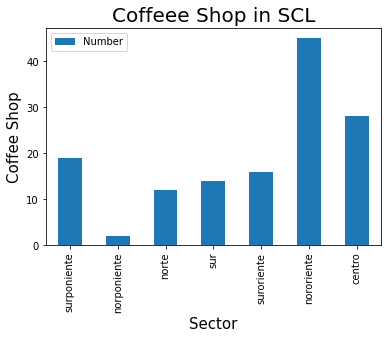

In [13]:
data_sec.plot.bar(x='Sector',y='Number')
plt.title('Coffeee Shop in SCL', fontsize = 20)
plt.xlabel('Sector', fontsize = 15)
plt.ylabel('Coffee Shop', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

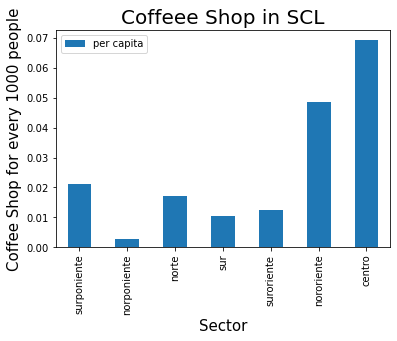

In [14]:
data_sec.plot.bar(x='Sector',y='per capita')
plt.title('Coffeee Shop in SCL', fontsize = 20)
plt.xlabel('Sector', fontsize = 15)
plt.ylabel('Coffee Shop for every 1000 people', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

So, the areas where Santiago's Coffee Shops are more concentrated are in the city center, and in northeastern area (Centro and Nororiente). The analysis in the northeastern sector will be continued, since it has less density of Coffee Shops but still a high number

In [15]:
dataframe = dataframe.drop(dataframe[dataframe.Sector!='nororiente'].index).reset_index(drop=True)

In [16]:
dataframe['rating'] = np.nan
for i in np.arange(0,len(dataframe),1):
    
    url2 = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        dataframe['Id'][i],
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    res = requests.get(url2).json()
    try:
        dataframe.loc[i,'rating'] = res['response']['venue']['rating']
    except KeyError:
        pass

In [17]:
dataframe.head(42)

,Name,Categorie,Id,Address,Comuna,Sector,Latitude,Longitude,rating
0,Starbucks,Coffee Shop,4b6c4086f964a520ca2b2ce3,Av. Príncipe de Gales 6803,La Reina,nororiente,-33.438917,-70.561624,7.5
1,Quererte,Coffee Shop,535199b3498e2fc719e84ab9,Av. Cristóbal Colón 6560 Local 10,Las Condes,nororiente,-33.417069,-70.560656,8.2
2,Starbucks,Coffee Shop,58b2ed4fc0c89b4f323d0d09,NaN,La Reina,nororiente,-33.447373,-70.533412,7.9
3,Trufa Cafetería Gourmet,Coffee Shop,53fa8341498eacb60d6c591a,Simon Bolivar 4744,Ñuñoa,nororiente,-33.448299,-70.581196,7.9
4,Assaggio Caffe,Coffee Shop,5570b454498e9146678fe2a9,Pucara 4312 Local C,Ñuñoa,nororiente,-33.444498,-70.585879,8.1
5,Café Montenegro,Café,561ebada498e8e44b7066f0c,Presidente Battle Y Ordoñez 4387,Ñuñoa,nororiente,-33.451589,-70.585321,8.0
6,Starbucks,Coffee Shop,4bc369caabf49521a2b9c393,General Blanche 11860,Las Condes,nororiente,-33.402361,-70.516780,7.8
7,Starbucks,Coffee Shop,512e13fee4b0f037c374ac98,Camino Las Flores 12640 Loc. 1,Las Condes,nororiente,-33.395732,-70.506590,8.0
8,Quererte,Coffee Shop,535199b3498e2fc719e84ab9,Av. Cristóbal Colón 6560 Local 10,Las Condes,nororiente,-33.417069,-70.560656,8.2
9,Huerto Sur,Café,525bdf1811d2fce17fb032dc,Estoril 50,Las Condes,nororiente,-33.383700,-70.533415,7.7


In [18]:
data_com = pd.DataFrame(columns=['Comuna', 'Number', 'Percapita','Rating'])
data_com['Comuna'] =dataframe['Comuna'].unique()

for i in data_com.Comuna:
    data_com.Rating.loc[data_com.Comuna==i] = dataframe.loc[dataframe.Comuna==i,'rating'].mean()
    data_com.Number.loc[data_com.Comuna==i] = sum(dataframe.Comuna==i)
    data_com.Percapita.loc[data_com.Comuna==i] = sum(dataframe.Comuna==i)*1000/int(df.loc[df[df.Comuna==i].index[0],'Población'])

In [19]:
data_com.head()

,Comuna,Number,Percapita,Rating
0,La Reina,3,0.0323321,7.63333
1,Las Condes,7,0.0237419,7.85714
2,Ñuñoa,14,0.0672311,8.35
3,Providencia,17,0.119652,8.37059
4,Vitacura,4,0.0468472,8


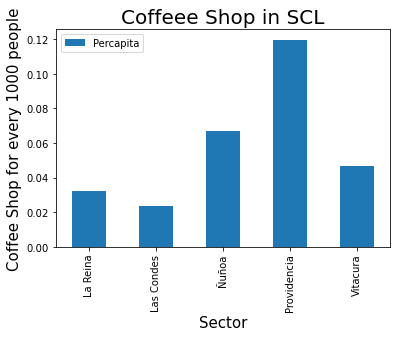

In [20]:
data_com.plot.bar(x='Comuna',y='Percapita')
plt.title('Coffeee Shop in SCL', fontsize = 20)
plt.xlabel('Sector', fontsize = 15)
plt.ylabel('Coffee Shop for every 1000 people', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.show()

Above it is shown that Coffee Shops have lower concentrations in Las Condes, Ñuñoa and Vitacura. The next plot shows that the best average ratings of Coffee Shops are in Providencia and Ñuñoa.

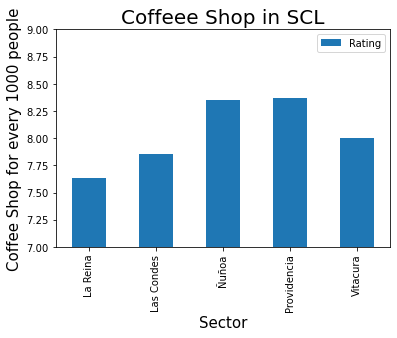

In [21]:
data_com.plot.bar(x='Comuna',y='Rating')
plt.title('Coffeee Shop in SCL', fontsize = 20)
plt.xlabel('Sector', fontsize = 15)
plt.ylabel('Coffee Shop for every 1000 people', fontsize=15)
plt.xticks(rotation = 'vertical')
plt.ylim([7,9])
plt.show()

In [22]:
map_com = folium.Map(location=[-33.417069088120954, -70.56065629493385], zoom_start=12)
l=-1

path = r'C:/Users/icald/OneDrive/Escritorio/Proyectos/coursera/Comunas/'
color = ['red','green','blue','yellow','magenta','cyan','grey']
for j in data_com.Comuna:
    l +=1
    j = j.lower().replace(' ','_')
    j = reemplazar(j)
    p = path + j+'.geojson'
    map_com.choropleth(
        geo_data=p,
        label = j,
        fill_color= color[l],
        fill_opacity=0.7, 
        line_opacity=1,)

for lat, lng, com, nam in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Comuna'], dataframe['Name']):
    label = '{}, {}'.format(nam, com)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label).add_to(map_com)  
    
map_com

C:\Users\icald\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Discussions <a name="Discussions"></a>

The last image shows that there is a high concentration of Coffee Shops in the limit betweeen Providencia and Ñuñoa, creating a concentration of stores in the northern zone of the Comuna. This might be due to a special condition of the zone like a commercial area or office buildings that are attractive for Coffee and food business.

It must be noticed that the number of Coffee Shops might be higher, because it will depend if the place is registered in the Foursquare database and if it fits with the criteria imposed in the data analysis.

## Conclusion <a name="Conclusion"></a>

As a conclusion we can say that the optimal place to locate a new Coffee Shop in Santiago de Chile, it's in the Comuna of Ñuñoa, since it shows a balance between the concentration of stores and the average rating. It is noticed that the Coffee Shops in Ñuñoa are concentrated in the north area of the Comuna, so further analysis will be necessary to find an ideal spot to place a new Coffee Shop within this Comuna.